## Bad Angle Detection

### Curvature Comparisons

#### Code:

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pylab as pl
from math import sqrt
from skimage.filters import threshold_otsu
from skimage import measure
import os
import re
import itertools as it
import csv
import pandas as pd
from PIL import Image
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)
pl.ion()

In [3]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

In [2]:
def get_cont_mgac(image):
    gimage = inverse_gaussian_gradient(image)
    # Initial level set
    init_ls = np.zeros(image.shape, dtype=np.int8)
    init_ls[10:-10, 10:-10] = 1
    # List with intermediate results for plotting the evolution
    evolution = []
    callback = store_evolution_in(evolution)
    ls = morphological_geodesic_active_contour(gimage, 230, init_ls,
                                               smoothing=1, balloon=-1,
                                               threshold=0.69,
                                               iter_callback=callback)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    v = ax.contour(ls, [0.5], colors='r')
    t = v.collections[0].get_paths()
    k = 0
    for i in range(0,len(t)):
        if len(t[i]) >= len(t[k]):
            k = i
    X, Y = v.collections[0].get_paths()[k].vertices.T
    plt.close()
    return X,Y

In [83]:
def find_closest(points,x):
    k = 0;
    diff_min = abs(points[0]-x)
    for i in range(0,len(points)):
        diff =  abs(points[i] - x)
        if diff <= diff_min:
            diff_min = diff
            k = i
    return k

In [123]:
def get_curvature(x,y):

    dx = np.gradient(x)
    dy = np.gradient(y)

    d2x = np.gradient(dx)
    d2y = np.gradient(dy)

    cv = np.abs(dx * d2y - d2x * dy) / ((dx * dx + dy * dy)**1.5)
    
    return cv

In [191]:
def get_top_bot_curvature(x,y,k):
    ub1 = np.max(y)
    lb2 = np.min(y)
    tnth = (ub1 - lb2)/10
    lb1 = ub1 - tnth
    ub2 = lb2 + tnth

    top = []
    bot = []

    for i in range(0,len(x)):
        if lb1 <= y[i] <= ub1:
            top.append(i)
        if lb2 <= y[i] <= ub2:
            bot.append(i)
            
    xmid = np.min(x) + (np.max(x)-np.min(x))/2

    bot_mid = find_closest(x[bot],xmid)
    top_mid = find_closest(x[top],xmid)

    bot_mid = bot[bot_mid]
    top_mid = top[top_mid]
    
    bot_rng = np.mod(list(range(bot_mid-25,bot_mid+26)),len(x))
    top_rng = np.mod(list(range(top_mid-25,top_mid+26)),len(x))
    
    cv_bot = get_curvature(x[bot_rng],y[bot_rng])
    cv_top = get_curvature(x[top_rng],y[top_rng])
    
    return np.round(np.average(cv_top),k), np.round(np.average(cv_bot),k), top_rng, bot_rng


#### Test:

In [192]:
image_grey = data.load('C:\\Users\\arian\\Dropbox\\arianna_phd\\Pots\\Original_Images\\amphora_611_Leiden.bmp',as_grey=True)

In [193]:
x,y = get_cont_mgac(image_grey)

Text(0.5, 1.0, 'C1 = 0.23, C2 = 0.101')

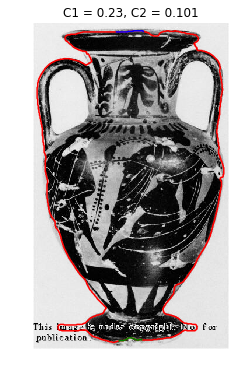

In [194]:
c1,c2,top,bot = get_top_bot_curvature(x,y,3)

fig, ax = plt.subplots(figsize=(4, 6))

ax.imshow(image_grey, cmap="gray")
ax.set_axis_off()
ax.plot(x,y,'-r',x[top],y[top],'-g',x[bot],y[bot],'-b')
ax.set_title("C1 = "+str(c1)+", C2 = "+str(c2), fontsize=12)

#### Bulk Test:

In [195]:
directory = os.fsencode('C:\\Users\\arian\\Dropbox\\arianna_phd\\Pots\\Original_Images')

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".bmp") or filename.endswith(".jpeg"): 
        nme = re.search('[a-z]+..\d+',filename).group(0)
        print("Now extracting from: "+str(nme))

        image_grey = data.load('C:\\Users\\arian\\Dropbox\\arianna_phd\\Pots\\Original_Images\\'+str(filename),as_grey=True)
        
        x,y = get_cont_mgac(image_grey)
        
        c1,c2,top,bot = get_top_bot_curvature(x,y,3)

        fig, ax = plt.subplots(figsize=(4, 6))

        ax.imshow(image_grey, cmap="gray")
        ax.set_axis_off()
        ax.plot(x,y,'-r',x[top],y[top],'-g',x[bot],y[bot],'-b')
        ax.set_title("C1 = "+str(c1)+", C2 = "+str(c2), fontsize=12)
        
        plt.savefig(str(nme)+"_top_bot_curv.png")
        plt.close()


Now extracting from: amphora_26
Now extracting from: amphora_467
Now extracting from: amphora_4
Now extracting from: amphora_51
Now extracting from: amphora_611
Now extracting from: amphora_612
Now extracting from: amphora_613
Now extracting from: amphora_614
Now extracting from: amphora_7052
Now extracting from: amphora_7073
Now extracting from: amphora_7074
Now extracting from: amphora_7077
Now extracting from: amphora_7085
Now extracting from: amphora_7202
Now extracting from: amphora_85
Now extracting from: amphora__11
Now extracting from: bellkrater_2194
Now extracting from: bellkrater_2462
Now extracting from: bellkrater_3559
Now extracting from: bellkrater_5038
Now extracting from: bellkrater_5039
Now extracting from: bellkrater_5447
Now extracting from: bellkrater_568


C:\Users\arian\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Now extracting from: bellkrater_574
Now extracting from: bellkrater_7408
Now extracting from: bellkrater_7847
Now extracting from: colkrater_10413
Now extracting from: colkrater_1205
Now extracting from: colkrater_20578
Now extracting from: colkrater_237
Now extracting from: colkrater_2402
Now extracting from: colkrater_25683
Now extracting from: colkrater_4367
Now extracting from: colkrater_4837
Now extracting from: colkrater_643
Now extracting from: colkrater_8937
